INICIANDO MODELO LSTM PARA CONSUMO DE GLP

🔧 Buscando mejores parámetros...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

✅ Mejores parámetros: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__learning_rate': 0.01, 'model__seq_length': 12, 'model__units': 50}
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0258 - val_loss: 0.0027
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0066 - val_loss: 0.0035
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 11/5

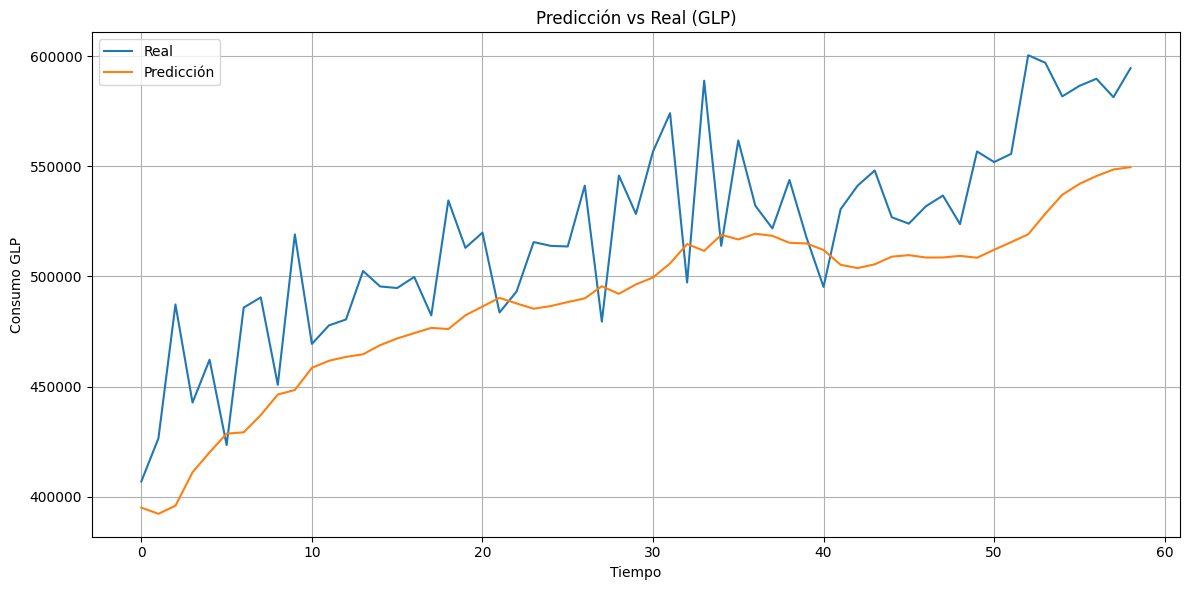

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipython-input-2-3171586377.py:123: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


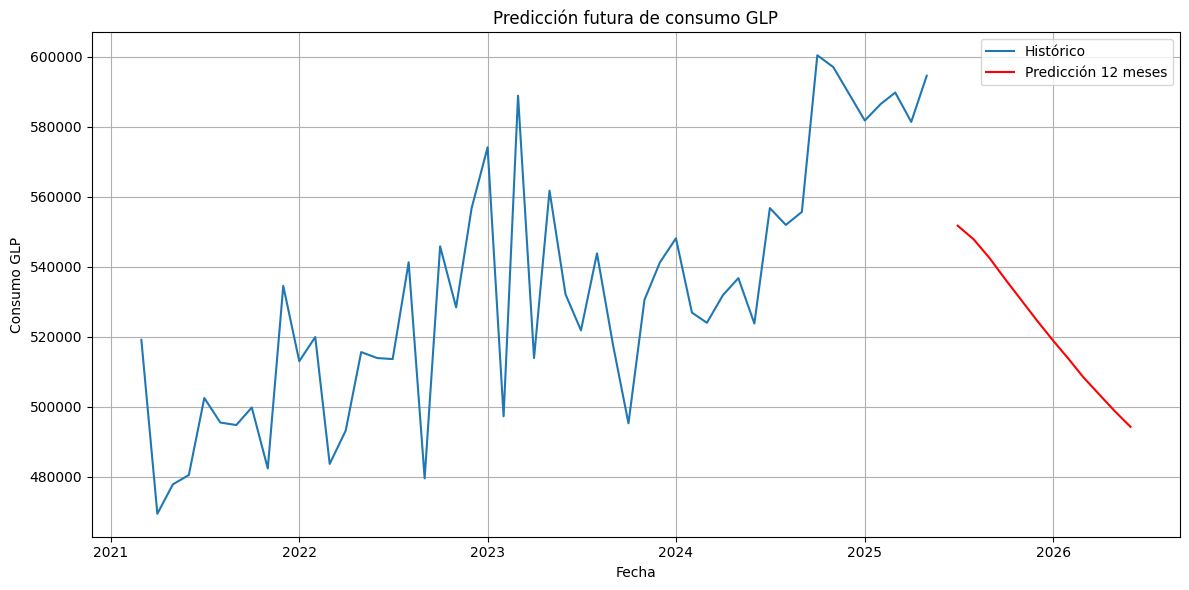

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
import tensorflow as tf

# Configuración
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.float_format = '{:,.2f}'.format

# Cargar datos
def cargar_datos():
    df = pd.read_excel('CONSUMO-HIDROCARBUROS-2024-2025.xlsx', sheet_name='CONSUMO')
    df.columns = df.columns.str.strip().str.lower()
    df = df.rename(columns={'gas licuado de petróleo': 'glp'})
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
    df.dropna(subset=['fecha'], inplace=True)
    df.set_index('fecha', inplace=True)
    df.sort_index(inplace=True)
    return df

# Preparar datos
def crear_secuencias(datos, seq_length):
    X, y = [], []
    for i in range(len(datos) - seq_length):
        X.append(datos[i:(i + seq_length)])
        y.append(datos[i + seq_length])
    return np.array(X), np.array(y)

def crear_modelo(units=50, dropout_rate=0.2, learning_rate=0.01, seq_length=12):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units // 2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Main
def main():
    print("="*50)
    print("INICIANDO MODELO LSTM PARA CONSUMO DE GLP")
    print("="*50)

    df = cargar_datos()
    data = df['glp'].dropna().values.reshape(-1, 1)

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    seq_length = 12
    X, y = crear_secuencias(data_scaled, seq_length)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print("\n🔧 Buscando mejores parámetros...")
    model = KerasRegressor(model=crear_modelo, verbose=0)
    param_grid = {
        'model__units': [50],
        'model__dropout_rate': [0.2],
        'model__learning_rate': [0.01],
        'batch_size': [32],
        'epochs': [50],
        'model__seq_length': [seq_length]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_result = grid.fit(X_train, y_train)

    print(f"✅ Mejores parámetros: {grid_result.best_params_}")

    best_model = crear_modelo(**{
        k.replace('model__', ''): v for k, v in grid_result.best_params_.items() if 'model__' in k
    })

    history = best_model.fit(X_train, y_train,
                             epochs=grid_result.best_params_['epochs'],
                             batch_size=grid_result.best_params_['batch_size'],
                             validation_split=0.1,
                             verbose=1)

    y_pred = best_model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

    print("\n📊 Métricas:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    plt.plot(y_test_inv, label='Real')
    plt.plot(y_pred_inv, label='Predicción')
    plt.title('Predicción vs Real (GLP)')
    plt.xlabel('Tiempo')
    plt.ylabel('Consumo GLP')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Predicción a futuro (12 meses)
    future_preds = []
    current_sequence = data_scaled[-seq_length:]
    for _ in range(12):
        pred = best_model.predict(current_sequence.reshape(1, seq_length, 1))
        future_preds.append(pred[0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred[0]

    future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
    future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

    plt.plot(df.index[-50:], scaler.inverse_transform(data_scaled[-50:]), label='Histórico')
    plt.plot(future_index, future_preds_inv, label='Predicción 12 meses', color='red')
    plt.title('Predicción futura de consumo GLP')
    plt.xlabel('Fecha')
    plt.ylabel('Consumo GLP')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
